_Presented by Irene Rivadeneyra on March 16, 2022_

# PySAL and Exploratory Spatial Descriptive Analysis (ESDA): `esda`,`splot`, and  `mgwr`

In today's session we introduce **_Python's PySAL ecosystem_** (Python Spatial Analysis Library). This material is meant to help students analyze their data through a geographic lens, quantifying spatial structure and pattern detection, and visualizing it, providing insights for their projects. 

`esda` considers **attribute** + **location** of the data.

`splot` considers **spatial statistics from PySAL** + **matplotlib**.

`mgwr` allows us to carry out **Multi-scale Geographic Weighted Regression**.


# Exploring PySAL

* Notebooks: http://pysal.org/notebooks/intro.html

* Repositories: https://github.com/pysal

* Tutorials: http://pysal.org/getting_started

<img src="images/pysal_libraries.png" width='800' height='1000'>

In [ ]:
# Install libraries

In [ ]:
! pip install libpysal

In [ ]:
! pip install splot

In [ ]:
! pip install esda

In [ ]:
! pip install mgwr

In [ ]:
! pip install contextily

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as ps
import matplotlib.pyplot as plt
import matplotlib as mpl

#For basemap:
import contextily as cx

#For regression:
import statsmodels.api as sm
import numpy as np
from patsy import dmatrices

import esda as esda
from esda.moran import Moran_Local
import splot as splot

#Plot spatial weights:
from libpysal.weights.contiguity import Queen
from splot.libpysal import plot_spatial_weights
from splot.esda import moran_scatterplot, plot_moran
from splot.esda import plot_local_autocorrelation

# For GWR
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap

## [Example using Mexico City's socioeconomic data for 2010, 2015, and 2020](https://www.coneval.org.mx/Medicion/Paginas/Pobreza-municipio-2010-2020.aspx) 

The data consists of the 76 municipalities in Mexico City's metropolitan area.

<AxesSubplot:>

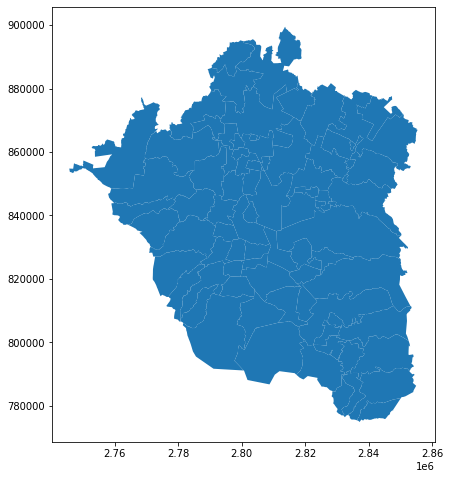

In [4]:
#Read in data and plot it 
gdf = gpd.read_file('../data/mx_city_metro.shp')
gdf.plot(figsize=(8,8))

<img src="images/codebook.png" width='1000' height='1000'>

In [5]:
gdf.head(5)

,ID,ID_TEXT,state,state_name,mun,mun_name,pop_10,pop_15,pop_20,ppov_10,...,pfood_10,pfood_15,pfood_20,ping1_10,ping1_15,ping1_20,ping2_10,ping2_15,ping2_20,geometry
0,9002.0,09002,09,Ciudad de México,002,Azcapotzalco,414075.0,400254.0,404958.0,17.4,...,9.2,7.1,10.9,25.2,30.4,35.9,3.1,5.4,10.3,"POLYGON ((2794859.977 837218.408, 2794861.690 ..."
1,9003.0,09003,09,Ciudad de México,003,Coyoacán,572547.0,572991.0,568913.0,18.2,...,15.0,7.9,11.9,21.3,27.4,38.1,3.1,4.9,12.5,"POLYGON ((2800218.995 820661.624, 2800250.439 ..."
2,9004.0,09004,09,Ciudad de México,004,Cuajimalpa de Morelos,197706.0,185835.0,199872.0,32.5,...,12.4,11.8,15.1,37.9,36.5,41.6,6.4,6.5,13.5,"POLYGON ((2787229.791 825329.285, 2787272.744 ..."
3,9005.0,09005,09,Ciudad de México,005,Gustavo A. Madero,1284401.0,1215014.0,1130265.0,31.2,...,12.1,10.8,17.6,39.4,39.9,46.2,7.1,8.3,15.2,"POLYGON ((2802175.660 843326.718, 2801806.564 ..."
4,9006.0,09006,09,Ciudad de México,006,Iztacalco,398140.0,358195.0,376976.0,25.9,...,8.2,8.7,13.2,32.7,22.9,34.2,6.0,3.8,10.3,"POLYGON ((2808145.908 826363.205, 2808144.575 ..."


In [6]:
#Which projection is it?
gdf.crs

<Projected CRS: PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_GRS 1 ...>
Name: Lambert_Conformal_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: GRS80
- Prime Meridian: Greenwich

In [7]:
# We will estimate distances between centroids of community areas, so we have to project it in meters using a different projection:
gdf_3857=gdf.to_crs("EPSG:3857")
print('Check that it transformed the projection: ', gdf_3857.crs)
gdf_3857.crs

Check that it transformed the projection:  EPSG:3857


<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
#Add centroids to table
gdf_3857["x"] = gdf_3857.centroid.map(lambda p: p.x)
gdf_3857["y"] = gdf_3857.centroid.map(lambda p: p.y)
gdf_3857.head(4)

,ID,ID_TEXT,state,state_name,mun,mun_name,pop_10,pop_15,pop_20,ppov_10,...,pfood_20,ping1_10,ping1_15,ping1_20,ping2_10,ping2_15,ping2_20,geometry,x,y
0,9002.0,09002,09,Ciudad de México,002,Azcapotzalco,414075.0,400254.0,404958.0,17.4,...,10.9,25.2,30.4,35.9,3.1,5.4,10.3,"POLYGON ((-11040923.908 2214775.451, -11040922...",-1.104090e+07,2.212160e+06
1,9003.0,09003,09,Ciudad de México,003,Coyoacán,572547.0,572991.0,568913.0,18.2,...,11.9,21.3,27.4,38.1,3.1,4.9,12.5,"POLYGON ((-11035576.513 2196958.111, -11035543...",-1.103737e+07,2.193434e+06
2,9004.0,09004,09,Ciudad de México,004,Cuajimalpa de Morelos,197706.0,185835.0,199872.0,32.5,...,15.1,37.9,36.5,41.6,6.4,6.5,13.5,"POLYGON ((-11049280.516 2202218.722, -11049236...",-1.105524e+07,2.193159e+06
3,9005.0,09005,09,Ciudad de México,005,Gustavo A. Madero,1284401.0,1215014.0,1130265.0,31.2,...,17.6,39.4,39.9,46.2,7.1,8.3,15.2,"POLYGON ((-11033012.896 2221156.029, -11033414...",-1.103353e+07,2.214374e+06


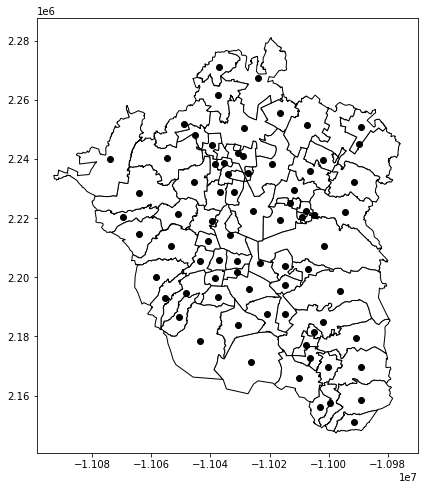

In [9]:
fig, ax = plt.subplots(figsize = (8, 8))
gdf_3857.plot(ax=ax, **{'edgecolor': 'black', 'facecolor': 'white'})
gdf_3857.centroid.plot(ax = ax, c = 'black')
plt.show()

#### Let's start the analysis!

In [10]:
#See what's inside our data
gdf.columns

Index(['ID', 'ID_TEXT', 'state', 'state_name', 'mun', 'mun_name', 'pop_10',
       'pop_15', 'pop_20', 'ppov_10', 'ppov_15', 'ppov_20', 'pepov_10',
       'pepov_15', 'pepov_20', 'peduc_10', 'peduc_15', 'peduc_20', 'pheal_10',
       'pheal_15', 'pheal_20', 'pss_10', 'pss_15', 'pss_20', 'pqdwel_10',
       'pqdwel_15', 'pqdwel_20', 'pserv_10', 'pserv_15', 'pserv_20',
       'pfood_10', 'pfood_15', 'pfood_20', 'ping1_10', 'ping1_15', 'ping1_20',
       'ping2_10', 'ping2_15', 'ping2_20', 'geometry'],
      dtype='object')

In [11]:
gdf[['ID','mun_name', 'ppov_20', 'pheal_20' , 'pqdwel_20', 'peduc_20']]

,ID,mun_name,ppov_20,pheal_20,pqdwel_20,peduc_20
0,9002.0,Azcapotzalco,24.2,20.7,3.5,6.3
1,9003.0,Coyoacán,27.1,22.8,3.0,5.6
2,9004.0,Cuajimalpa de Morelos,32.5,21.9,5.8,9.0
3,9005.0,Gustavo A. Madero,33.8,24.4,3.9,7.0
4,9006.0,Iztacalco,25.2,25.4,3.4,5.7
...,...,...,...,...,...,...
71,15084.0,Temascalapa,62.0,33.3,8.8,12.7
72,15089.0,Tenango del Aire,58.5,25.5,10.3,9.7
73,15099.0,Texcoco,56.4,36.4,10.2,10.7
74,15100.0,Tezoyuca,63.5,33.0,9.3,9.3


In [12]:
gdf[['mun_name', 'ppov_20', 'pheal_20' , 'pqdwel_20', 'peduc_20']].describe()

,ppov_20,pheal_20,pqdwel_20,peduc_20
count,76.000000,76.000000,76.000000,76.000000
mean,49.135526,32.114474,7.735526,10.185526
std,13.809182,6.476269,4.046915,2.722288
min,7.900000,19.700000,0.900000,2.900000
25%,41.700000,27.675000,4.950000,8.800000
50%,51.450000,31.750000,6.800000,10.150000
75%,59.825000,35.800000,10.200000,12.125000
max,75.600000,45.800000,18.100000,18.700000


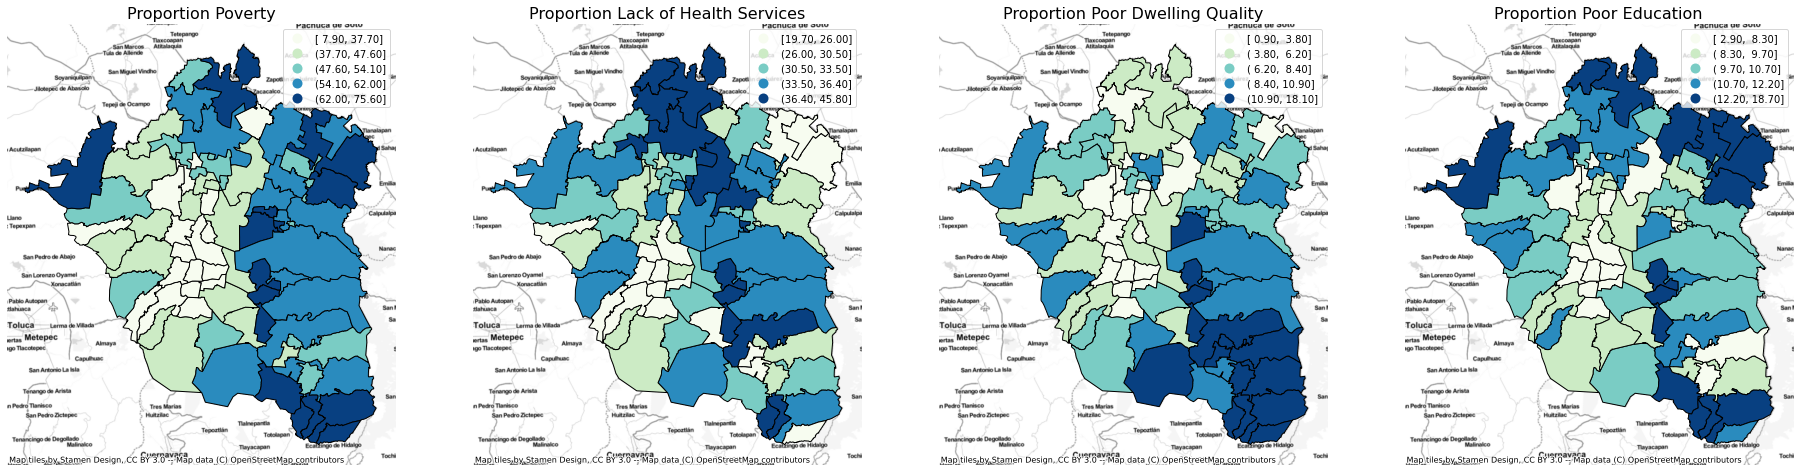

In [13]:
#Create choropleth quantile maps of each variable we will use
f,ax = plt.subplots(1,4,figsize=(32,34))

gdf.plot(column='ppov_20', legend=True, ax=ax[0],
        scheme="quantiles",  k=5, cmap='GnBu',edgecolor='black')

ax[0].set_title("Proportion Poverty", fontsize=16)

gdf.plot(column='pheal_20', legend=True, ax=ax[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[1].set_title("Proportion Lack of Health Services", fontsize=16)

gdf.plot(column='pqdwel_20', legend=True, ax=ax[2],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[2].set_title("Proportion Poor Dwelling Quality", fontsize=16)

gdf.plot(column='peduc_20', legend=True, ax=ax[3],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[3].set_title("Proportion Poor Education", fontsize=16)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')

cx.add_basemap(ax[0], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[2], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[3], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()


In [14]:
#As in last week, we run a regression:
y, X = dmatrices('ppov_20 ~  pheal_20  + pqdwel_20 + peduc_20', 
                 data=gdf, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                ppov_20   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     75.74
Date:                Wed, 16 Mar 2022   Prob (F-statistic):           3.20e-22
Time:                        01:11:15   Log-Likelihood:                -252.73
No. Observations:                  76   AIC:                             513.5
Df Residuals:                      72   BIC:                             522.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7335      4.204     -0.650      0.5

---
### Two main components of ESDA:
- **Spatial heterogeneity** (when attribute 'drifts' over space generating structural breaks in the data: North/South/East/West)
- **Spatial dependence or spatial autocorrelation** (Serves two purposes: data exploration or as diagnostic of regression -- assumption of independent errors)
    - Positive autocorrelation = spatial clustering
    - Negative autocorrelation = spatial outliers 

#### Spatial Autocorrelation ####
(Adapted from [Scipy-20 Tutorial](https://github.com/knaaptime/pysal-scipy20))

Discover spatial structure of our data. If the spatial distribution of people living below the poverty line was random, then we
should not see any clustering of similar values on the map. 

However, our brains are very powerful pattern recognition machines and sometimes
they can be too powerful and lead us to detect false positives, or patterns
where there are no statistical patterns.  
This is a particular concern when
dealing with visualization of irregular polygons of differning sizes and shapes.

The concept of *spatial autocorrelation* relates to the combination of two types of similarity: spatial
similarity and attribute similarity.  
Although there are many different measures
of spatial autocorrelation, they all combine these two types of simmilarity into
a summary measure.


#### Spatial Weights ####

In spatial autocorrelation analysis, the spatial weights are used to formalize the notion of spatial similarity.  

**Some types of weights**:
- Contiguity (examples include: Queen, Rook)
- Distance (examples include: k-nearest neighbors, Kernel Weights)


<img src="images/weights_ex.png" width='900' height='1000'>

#### Kernel Weights
Kernel Weights are continuous distance-based weights that use kernel densities to define the neighbor relationship.
Typically, they estimate a `bandwidth`, which is a parameter governing how far out observations should be considered neighboring.  
Then, using this bandwidth, they evaluate a continuous kernel function to provide a weight between 0 and 1.

Many different choices of kernel functions are supported, and bandwidths can either be **fixed** (constant over all units) or **adaptive** in function of unit density.

For example, if we want to use **adaptive bandwidths for the map and weight according to a gaussian kernel**:

#### Adaptive gaussian kernel weights

bandwidth = the distance to the kth nearest neighbor for each
                  observation
   
bandwith is changing across observations

<img src="images/kernel_w.png" width='1100' height='1000'>

Examples of fixed (left) and adaptive (right) bandwidth kernels. A fixed bandwidth can be problematic when populations are sparse.

In [15]:
#To estimate kernel weights, we need out projected data (gdf_3857)
kernelWa = ps.weights.Kernel.from_dataframe(gdf_3857, k=20, fixed=False, function='gaussian')

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

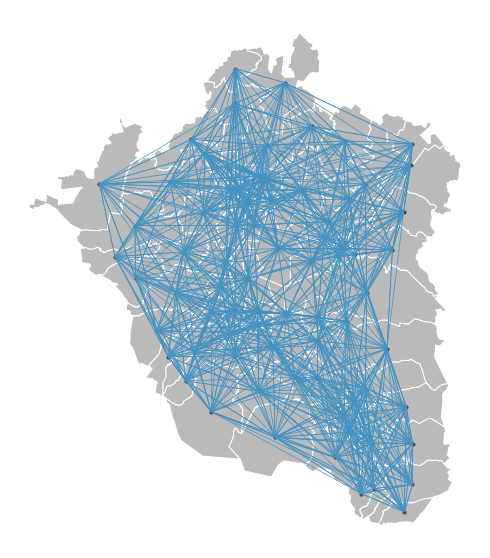

In [16]:
plot_spatial_weights(kernelWa, gdf_3857)

**There are many ways to define spatial weights, but to explore spatial autocorrelation, we will use queen contiguity weights:**

In [17]:
w = Queen.from_dataframe(gdf)

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

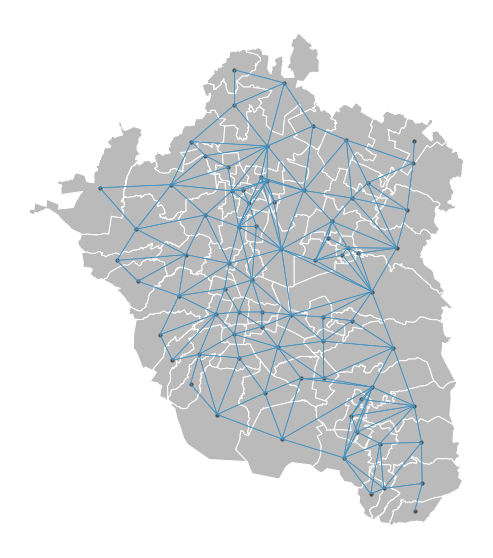

In [18]:
plot_spatial_weights(w, gdf)

---
# Local univariate spatial data analysis

## Global Spatial Autocorrelation
(Adapted from [esda_morans_viz.ipynb](http://pysal.org/notebooks/viz/splot/esda_morans_viz.html))

We calculate Moran's I. A test for global autocorrelation for a continuous attribute.

In [19]:
y, X = dmatrices('ppov_20 ~  pheal_20  + pqdwel_20 + peduc_20', 
                 data=gdf, return_type='dataframe')

In [20]:
#Estimating Moran's I for Proportion of People Below 185% Poverty Line:
moran = esda.Moran(y, w)
moran.I

0.6029149421288403

Our value for the statistic is interpreted against a reference distribution under the null hypothesis of complete spatial randomness.

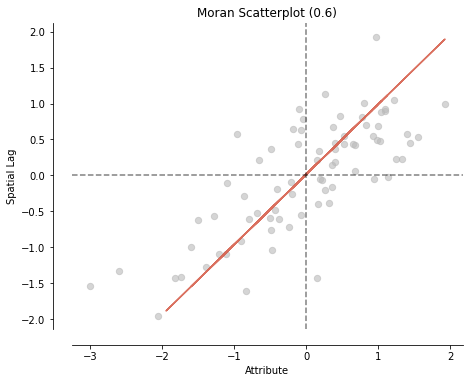

In [21]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

## Local Spatial Autocorrelation

As we showed above, the spatial weight between neighborhoods $i$ and $j$ indicates if the two 
are neighbors (i.e., geographically similar).  

What we also need is a measure of
attribute similarity to pair up with this concept of spatial similarity.  

The
**spatial lag** is a derived variable that accomplishes this for us. For neighborhood
$i$ the spatial lag is defined as: $$ylag_i = \sum_j w_{i,j} y_j$$

In addition to visualizing Global autocorrelation statistics, splot has options to visualize local autocorrelation statistics. We compute the local Moran. Then, we plot the spatial lag and the Pov185P variable in a Moran Scatterplot.

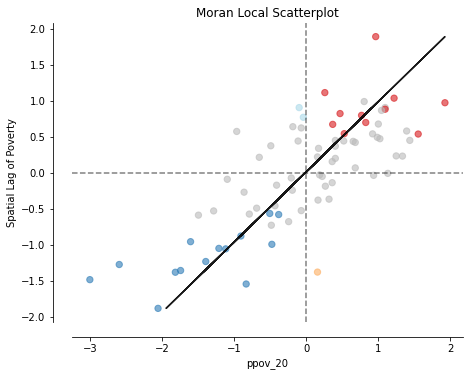

In [22]:
# calculate Moran_Local and plot
moran_loc = esda.moran.Moran_Local(y, w)
fig, ax =  splot.esda.moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('ppov_20')
ax.set_ylabel('Spatial Lag of Poverty')
plt.show()

We can distinguish the specific type of local spatial autocorrelation in High-High, Low-Low, High-Low, Low-High.
The upper right quadrant displays HH, the lower left, LL, the upper left LH and the lower right HL.

Let's now visualize the areas we found to be significant on a map:

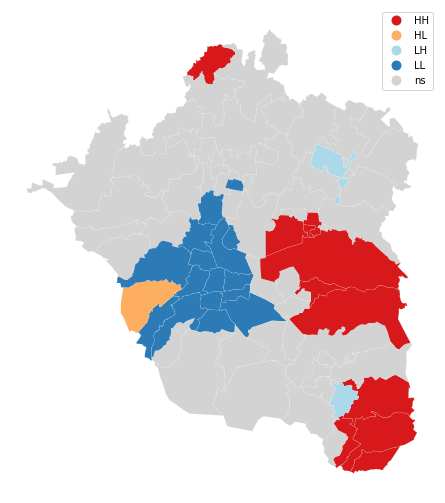

In [23]:
moran_loc = esda.moran.Moran_Local(y, w)
splot.esda.lisa_cluster(moran_loc, gdf, p=0.05, figsize = (9,9))
plt.show()

# Combined visualizations

Often, it is easier to asses the results by comparing different visualizations.
Here we for example look at a static visualization of a Moran Scatterplot, LISA cluster map and choropleth map.

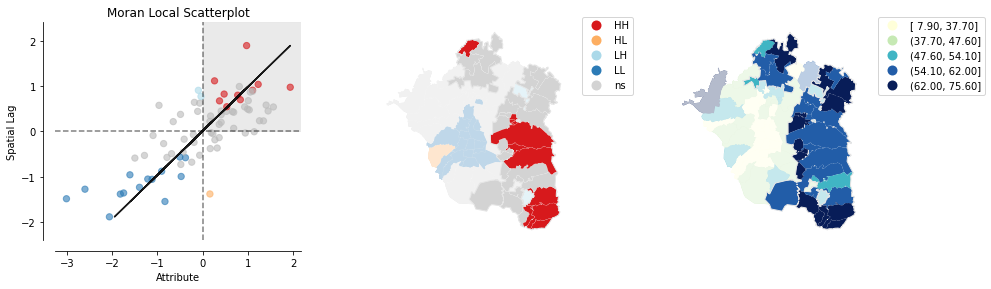

In [24]:
y = gdf['ppov_20'].values
w = Queen.from_dataframe(gdf)
w.transform = 'r'
moran_loc = Moran_Local(y, w)

fig = plot_local_autocorrelation(moran_loc, gdf, 'ppov_20', p=0.05, quadrant=1)
plt.show()

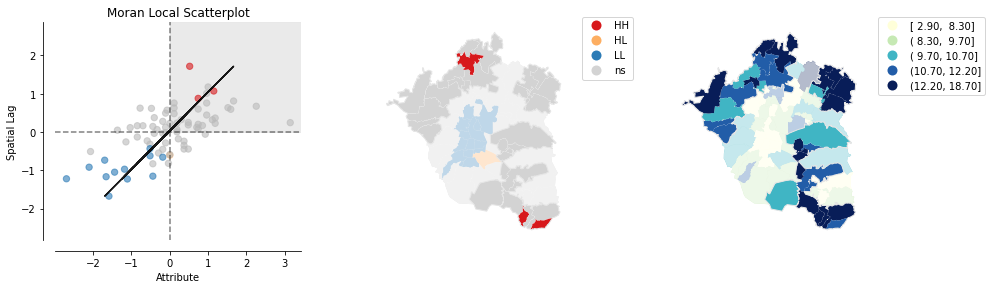

In [25]:
y = gdf['peduc_20'].values
w = Queen.from_dataframe(gdf)
w.transform = 'r'
moran_loc = Moran_Local(y, w)

fig = plot_local_autocorrelation(moran_loc, gdf, 'peduc_20', p=0.05, quadrant=1)
plt.show()

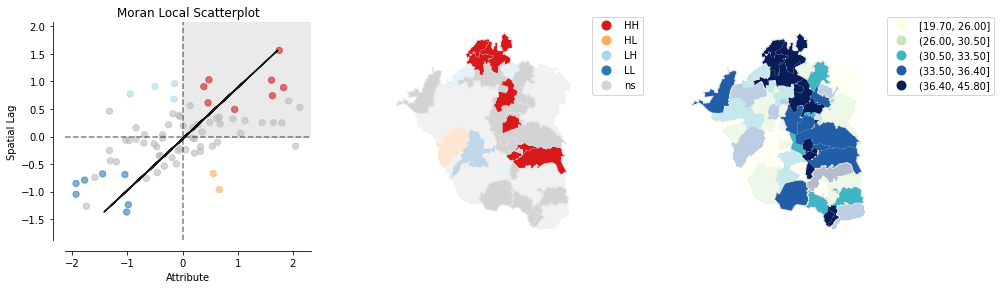

In [26]:
y = gdf['pheal_20'].values
w = Queen.from_dataframe(gdf)
w.transform = 'r'
moran_loc = Moran_Local(y, w)

fig = plot_local_autocorrelation(moran_loc, gdf, 'pheal_20', p=0.05, quadrant=1)
plt.show()


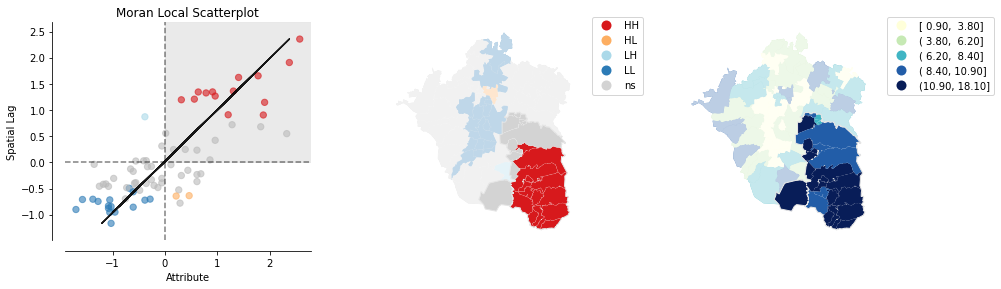

In [27]:
y = gdf['pqdwel_20'].values
w = Queen.from_dataframe(gdf)
w.transform = 'r'
moran_loc = Moran_Local(y, w)

fig = plot_local_autocorrelation(moran_loc, gdf, 'pqdwel_20', p=0.05, quadrant=1)
plt.show()

---
# Local multivariate spatial data analysis

## Geographically Weighted Regression (GWR) ##


- GWR is a tool for exploring and identifying the variation in statistical relationships over space (i.e. it treats spatial heterogeneity and tries to smooth it).
- In regression, we assume that errors are independent, but spatial autocorrelation invalidates this assumption!
- Uses kernel weights that smooth values over space (like a moving window).
- GWR estimator takes into account the weights matrix:   

$$ y_i = \beta_{0i} + \beta_{1i}X_{1i}+ \beta_{2i}X_{2i} + ... + \beta_{ki}X_{ki}+ \epsilon_i$$

$$\hat{\beta}_i = (X'W_iX)^{-1}X'W_iy$$

In [28]:
gdf_3857.head(2)

,ID,ID_TEXT,state,state_name,mun,mun_name,pop_10,pop_15,pop_20,ppov_10,...,pfood_20,ping1_10,ping1_15,ping1_20,ping2_10,ping2_15,ping2_20,geometry,x,y
0,9002.0,09002,09,Ciudad de México,002,Azcapotzalco,414075.0,400254.0,404958.0,17.4,...,10.9,25.2,30.4,35.9,3.1,5.4,10.3,"POLYGON ((-11040923.908 2214775.451, -11040922...",-1.104090e+07,2.212160e+06
1,9003.0,09003,09,Ciudad de México,003,Coyoacán,572547.0,572991.0,568913.0,18.2,...,11.9,21.3,27.4,38.1,3.1,4.9,12.5,"POLYGON ((-11035576.513 2196958.111, -11035543...",-1.103737e+07,2.193434e+06


In [30]:
#Prepare dataset inputs for GWR
g_y = gdf_3857['ppov_20'].values.reshape((-1, 1))
g_X = gdf_3857[['pheal_20', 'pqdwel_20', 'peduc_20']].values
u = gdf_3857['x']
v = gdf_3857['y']
g_coords = list(zip(u, v))


## Selection of bandwidth

### Manually

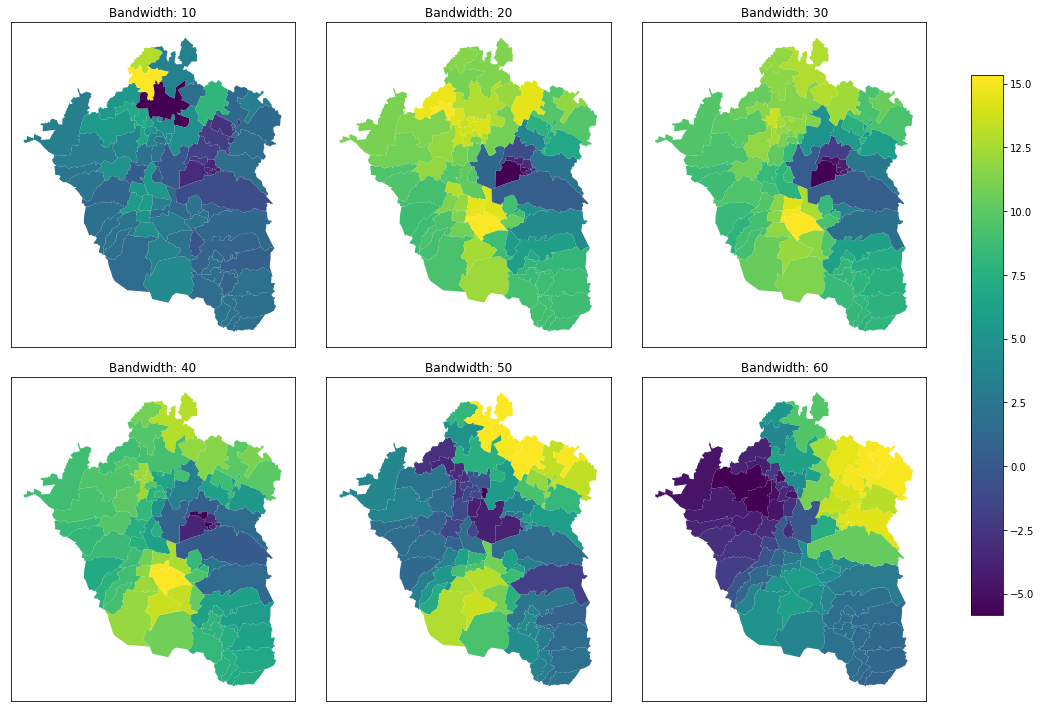

In [31]:
#Calibrate a GWR model for the Mexico City dataset using a manually set~bandwidth
#Exploring spatial heterogeneity by manually varying~bandwidth from 10 to 70 nearest neighbors
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
bws = (x for x in range(10, 70, 10))
vmins = []
vmaxs = []
for row in range(2):
     for col in range(3):
        bw = next(bws)
        gwr_model = GWR(g_coords, g_y, g_X, bw)
        gwr_results = gwr_model.fit()
        gdf_3857['pqdwel_20'] = gwr_results.params[:, -1]
        gdf_3857.plot('pqdwel_20', ax = ax[row, col])
        ax[row,col].set_title('Bandwidth: ' + str(bw))
        ax[row,col].get_xaxis().set_visible(False)
        ax[row,col].get_yaxis().set_visible(False)
        vmins.append(gdf_3857['pqdwel_20'].min())
        vmaxs.append(gdf_3857['pqdwel_20'].max())
        
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(vmins), vmax=max(vmaxs)))
fig.tight_layout()
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.show()

### Computationally

In [32]:
#Calibrate a GWR model for Chicago dataset using computationally selected~bandwidth (optimizes using AIC)
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
print('Computationally selected bandwidth: ',gwr_bw)

gwr_model = GWR(g_coords, g_y, g_X, gwr_bw)
gwr_results = gwr_model.fit()
print('Residual sum of squares: ', gwr_results.resid_ss)

Computationally selected bandwidth:  65.0
Residual sum of squares:  2213.624331810221


In [33]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                  76
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           3441.343
Log-likelihood:                                                    -252.729
AIC:                                                                513.458
AICc:                                                               516.315
BIC:                                                               3129.530
R2:                                                                   0.759
Adj. R2:                                                              0.749

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [34]:
#Prepare GWR results for mapping
#Add GWR parameters to GeoDataframe
gdf_3857['gwr_intercept'] = gwr_results.params[:,0]
gdf_3857['gwr_health'] = gwr_results.params[:,1]
gdf_3857['gwr_dwelling'] = gwr_results.params[:,2]
gdf_3857['gwr_educ'] = gwr_results.params[:,3]

#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()


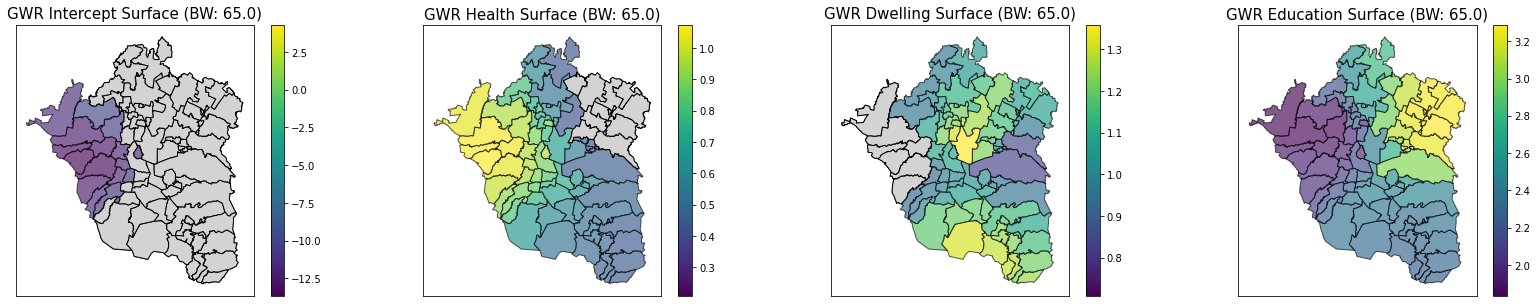

In [35]:
# Plot estimators
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28,5))
ax0 = axes[0]
ax0.set_title('GWR Intercept Surface (BW: ' + str(gwr_bw) +')', fontsize=15)
ax1 = axes[1]
ax1.set_title('GWR Health Surface (BW: ' + str(gwr_bw) +')', fontsize=15)
cmap = plt.cm.seismic
ax2 = axes[2]
ax2.set_title('GWR Dwelling Surface (BW: ' + str(gwr_bw) +')', fontsize=15)
ax3 = axes[3]
ax3.set_title('GWR Education Surface (BW: ' + str(gwr_bw) +')', fontsize=15)
cmap = plt.cm.seismic


gdf_3857.plot('gwr_intercept', legend=True, cmap=sm.cmap, ax=ax0,  **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,0] == 0).any():
    gdf_3857[gwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

gdf_3857.plot('gwr_health', legend=True,cmap=sm.cmap, ax=ax1,  **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,1] == 0).any():
    gdf_3857[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})
    
gdf_3857.plot('gwr_dwelling', legend=True, cmap=sm.cmap, ax=ax2,  **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,2] == 0).any():
    gdf_3857[gwr_filtered_t[:,2] == 0].plot(color='lightgrey', ax=ax2, **{'edgecolor':'black'})

gdf_3857.plot('gwr_educ', legend=True, cmap=sm.cmap, ax=ax3,  **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,3] == 0).any():
    gdf_3857[gwr_filtered_t[:,3] == 0].plot(color='lightgrey', ax=ax3, **{'edgecolor':'black'})

ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt.show()

Parameter estimates for the intercept surface show that for most of the city, the global results are not significant.  
However, percent Hispanic and percent low-birth weights show a higher estimate in the west downtown area and lower estimates in the south side.  
Firearm-related deaths show a high rate in the outskirts of the city, but still significant in the south side of Chicago.

#### You could also try doing **multi-scale GWR**, by _adjusting the bandwidth for each explanatory variable_.  
#### [Oshan et al. 2019](https://www.mdpi.com/2220-9964/8/6/269/htm ) provide a detailed example of it and provide code on how to make GWR estimations with larger n more efficient.

# Assessing fit

We can map out the R-squared to assess the fit of the model by geography. We find that the fit is better in the north than in the south side of Chicago.

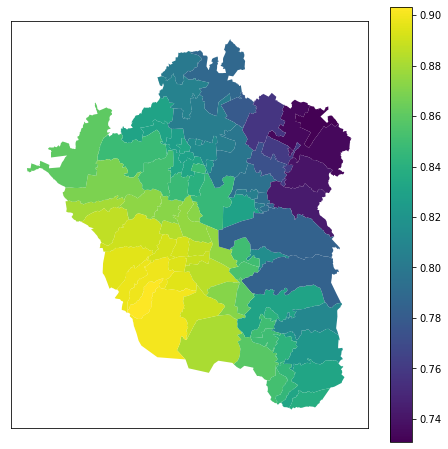

In [36]:
#Local model fit
gdf_3857['R2'] = gwr_results.localR2
gdf_3857.plot('R2', legend = True, figsize=(8,8))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#plt.savefig('local_R2')
plt.show()

### Better understanding fo the global model, but there are still problems with GWR:
- Local multicollinearity
- Data with spatially autocorrelated residuals fit with OLS rather than spatial regression model (MLE, IV/GMM)

#### Check for local multicollinearity

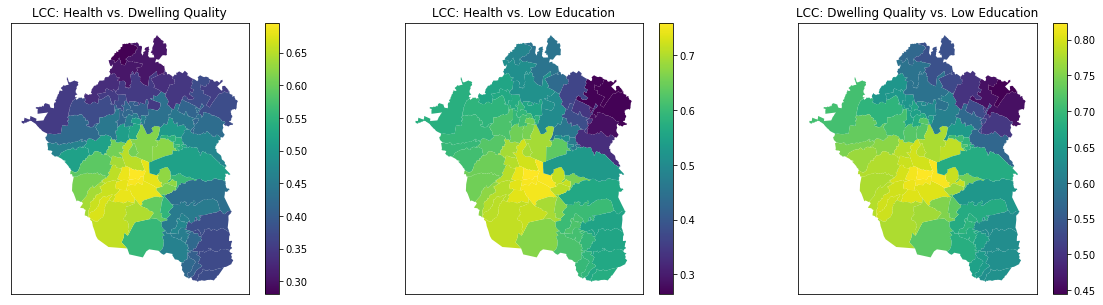

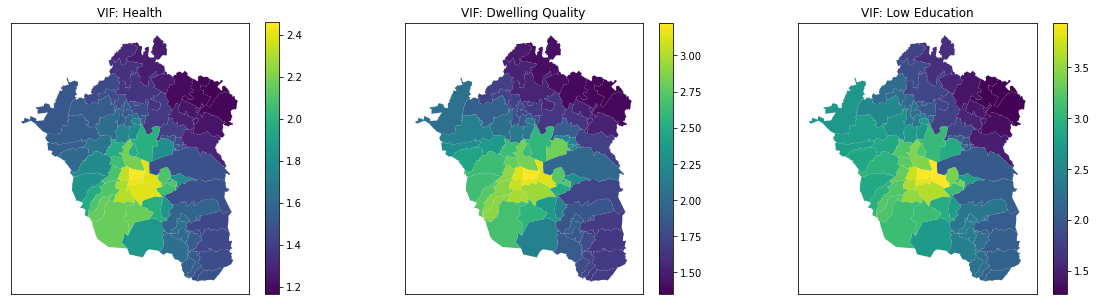

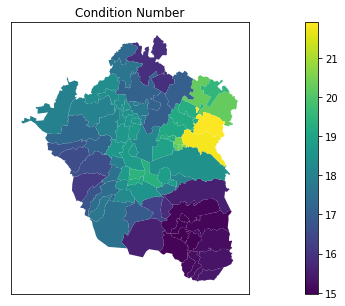

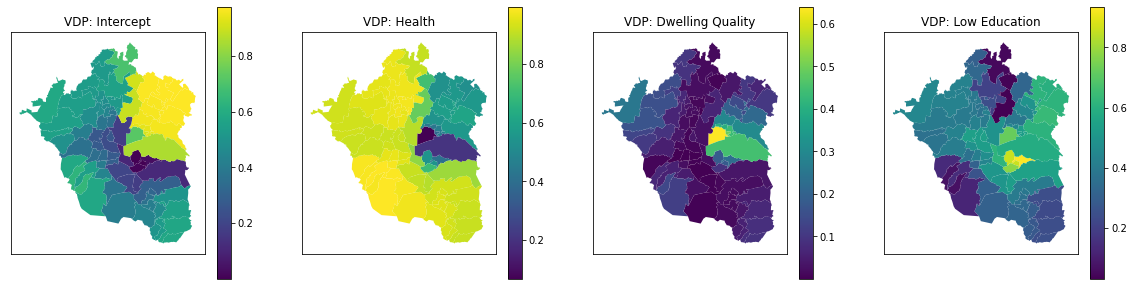

In [38]:
LCC, VIF, CN, VDP = gwr_results.local_collinearity()
names = ['Health vs. Dwelling Quality',
             'Health vs. Low Education',
             'Dwelling Quality vs. Low Education']
fig, ax = plt.subplots(1, 3, figsize = (20, 5))


for col in range(3):
    gdf_3857['vif'] = LCC[:, col]
    gdf_3857.plot('vif', ax = ax[col], legend = True)
    ax[col].set_title('LCC: ' + names[col])
    ax[col].get_xaxis().set_visible(False)
    ax[col].get_yaxis().set_visible(False)
names = ['Health', 'Dwelling Quality', 'Low Education']

fig, ax = plt.subplots(1, 3, figsize = (20, 5))
for col in range(3):
    gdf_3857['vif'] = VIF[:, col]
    gdf_3857.plot('vif', ax = ax[col], legend = True)
    ax[col].set_title('VIF: ' + names[col])
    ax[col].get_xaxis().set_visible(False)
    ax[col].get_yaxis().set_visible(False)
    
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
gdf_3857['cn'] = CN
gdf_3857.plot('cn', legend = True, ax = ax)
ax.set_title('Condition Number')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
names = ['Intercept', 'Health', 'Dwelling Quality', 'Low Education']

fig, ax = plt.subplots(1, 4, figsize = (20, 5))
for col in range(4):
    gdf_3857['vdp'] = VDP[:, col]
    gdf_3857.plot('vdp', ax = ax[col], legend = True)
    ax[col].set_title('VDP: ' + names[col])
    ax[col].get_xaxis().set_visible(False)
    ax[col].get_yaxis().set_visible(False)

Rules of thumb for indication of multicollinearity:  
- Problem with local correlation coefficients (LCC) if it is above 0.8. -> It seems there would be a multicollinearity issue between low birth weight and firearm-related deaths in the north side.  
- Problem with local variation inflation factors (VIF) if it is above 10. -> No problem
- Problem with local condition number (CN) if it is above 30. -> No problem
- Problem with local variation decomposition proportions (VDP) if it is above 0.5 -> Big problem

More likely to have multicollinearity.
Also could be an issue of scale mispecification?

# Bibliography
* **Notebooks**: http://pysal.org/notebooks/intro.html

* **Repositories**: https://github.com/pysal

* **Tutorials**: http://pysal.org/getting_started

- **On PySAL's ecosystem (specifics on installation and spatial statistics):** Kang, W. (2020). PySAL and Spatial Statistics Libraries. The Geographic Information Science & Technology Body of Knowledge (3rd Quarter 2020 Edition), John P. Wilson (ed.). https://doi.org/10.22224/gistbok/2020.3.1.  

- **Specifics on MGWR in PySAL:** Oshan, T. M., Li, Z., Kang, W., Wolf, L. J., & Fotheringham, A. S. (2019). mgwr: A Python implementation of multiscale geographically weighted regression for investigating process spatial heterogeneity and scale. ISPRS International Journal of Geo-Information, 8(6), 269. https://www.mdpi.com/2220-9964/8/6/269/htm  

- **Theoretical explanation of MGWR**: Fotheringham, A. S., Yang, W., & Kang, W. (2017). Multiscale geographically weighted regression (MGWR). Annals of the American Association of Geographers, 107(6), 1247-1265. https://www.tandfonline.com/doi/full/10.1080/24694452.2017.1352480?casa_token=vHMip5vHXScAAAAA%3AvoPQsgwqP9VAwUkRQfdfmckx7QgtMqSb3WERdwRqyfZj2jStDI2xQ4qUQVBBUC92LZ4qjDhLgwpw




<div class="alert alert-success" style="font-size:120%">
<b>YOUR TURN</b>: <br>
Try finding cold spots and hot spots in <b>your own data</b> through identifying patterns quantifying <b>local spatial autocorrelation</b>!  
    
How does it vary if you change the spatial weights or the p-value?
</div>